In [70]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load the Dataset

In [72]:
# Specify the file path
file_path = r"E:\Study\BDMA\ULB\Data Mining\SNCB Project\Dataset\dataset_ar41_for_ulb.csv"
chunk_size = 10000  #1000000 rows per chunk
for data in pd.read_csv(file_path, chunksize=chunk_size):
    data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Ploting Histogram for all numerical features

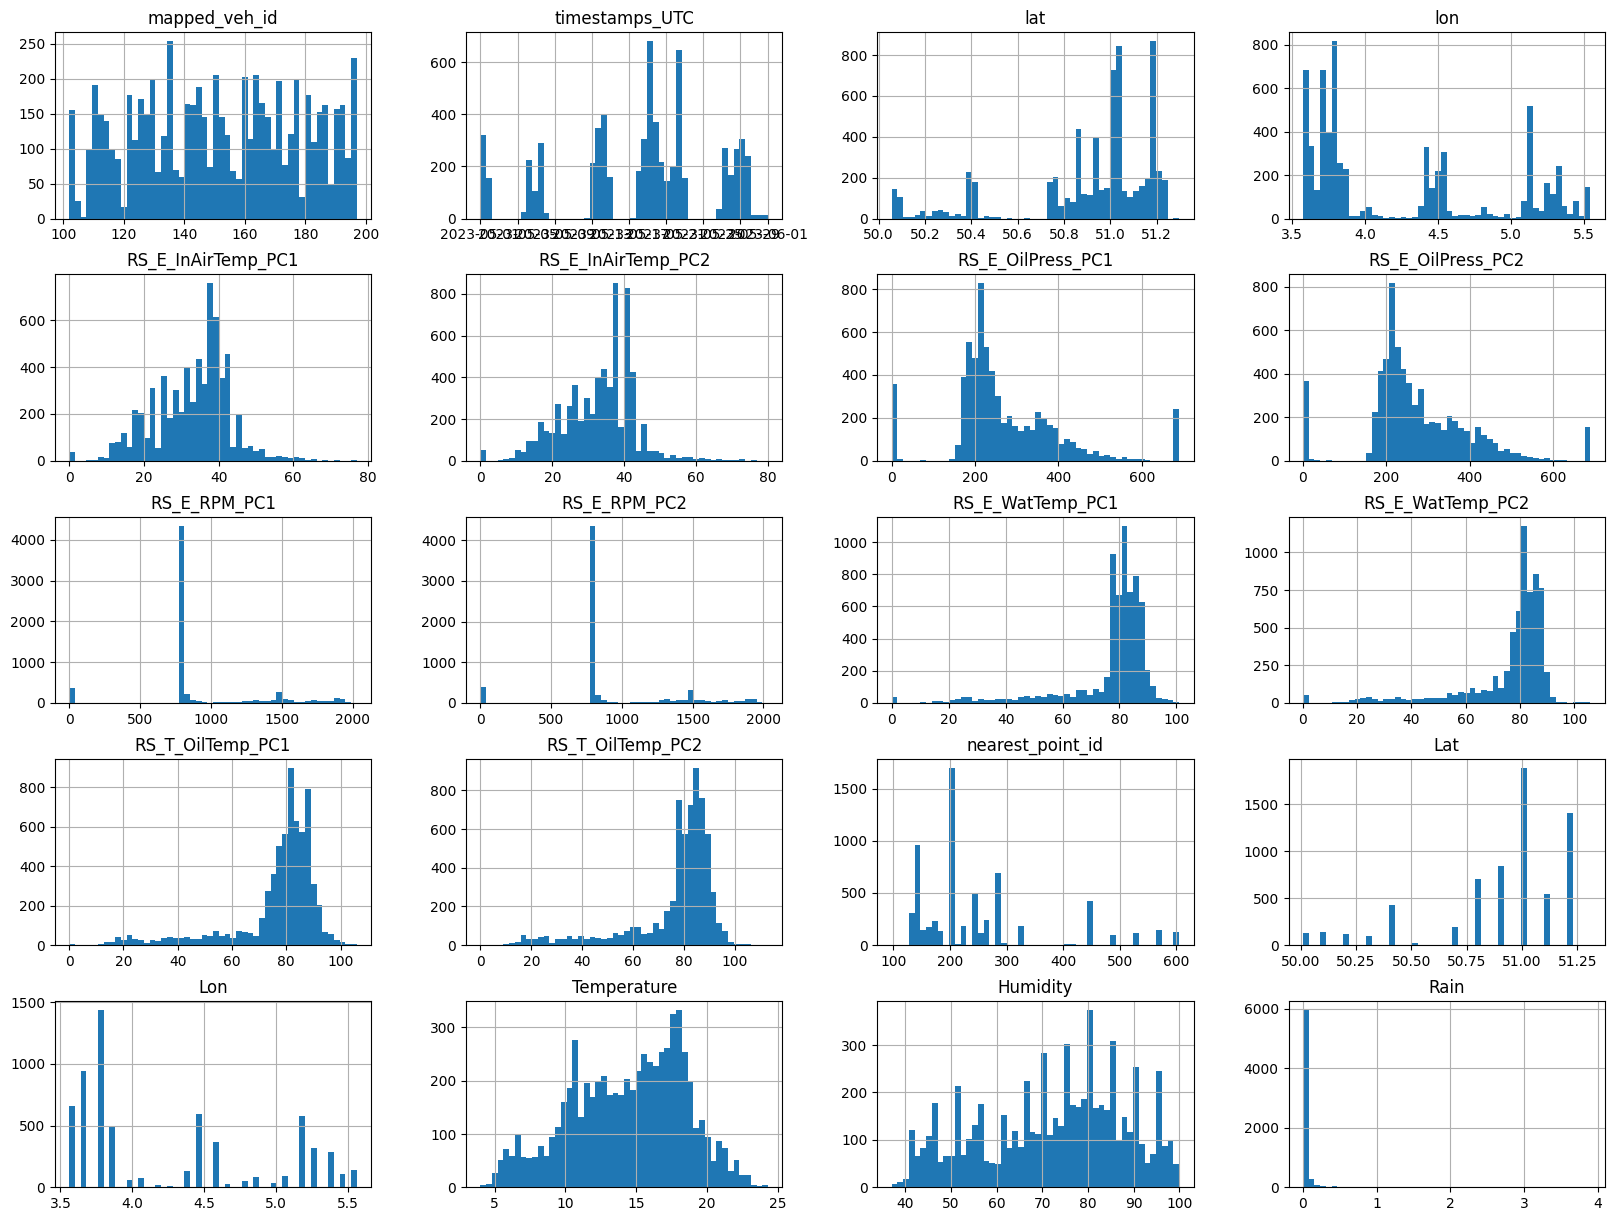

In [74]:
# Plot histograms for all numerical features to understand the distribution
data.hist(figsize=(20, 15), bins=50, layout=(5, 4))
plt.show()


# Correlation Matrix between numerical columns

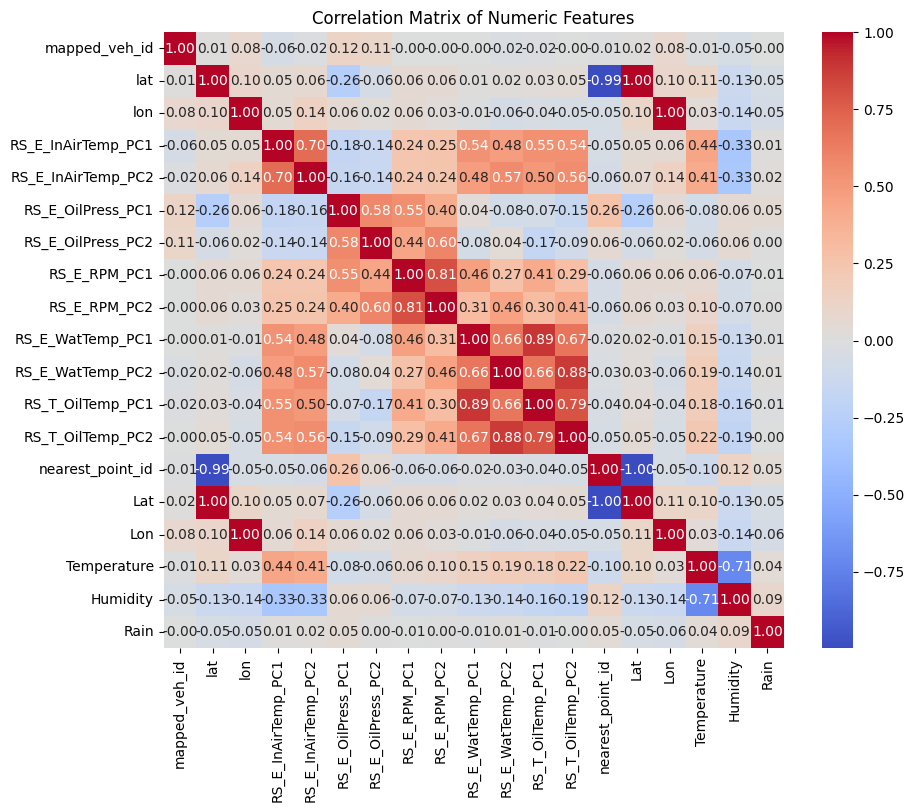

In [76]:
# Select only numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns only
corr_matrix = numeric_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Applying IQR method to flag the outliers for each column

In [50]:
# Define key columns to check for outliers
key_columns = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2']

# Function to flag outliers in a new column
def flag_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Flag as True if the value is an outlier
    outlier_flags = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    return outlier_flags

# Apply the flagging function to each key column and add a flag column to the DataFrame
for column in key_columns:
    flag_column_name = f'{column}_Outlier_Flag'
    data[flag_column_name] = flag_outliers(data, column)

# Now 'data' will have additional columns that flag outliers for each air temperature column
print(data.head())

          mapped_veh_id      timestamps_UTC        lat       lon   
17000000          109.0 2023-07-03 08:19:12  51.034368  3.715017  \
17000001          152.0 2023-07-13 01:38:37  50.401139  4.455334   
17000002          152.0 2023-07-03 08:33:22  50.411373  4.521866   
17000003          176.0 2023-07-13 01:39:30  51.015478  3.774571   
17000004          178.0 2023-07-03 09:04:05  51.040819  3.685786   

          RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1   
17000000                39.0                37.0              189.0  \
17000001                28.0                22.0              234.0   
17000002                35.0                33.0              231.0   
17000003                20.0                18.0              231.0   
17000004                28.0                30.0              196.0   

          RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  ...    Lat    Lon   
17000000              210.0         815.0         811.0  ...  51.01  3.761  \
17000001

# Plotting distributions of temperature, pressure and RPM

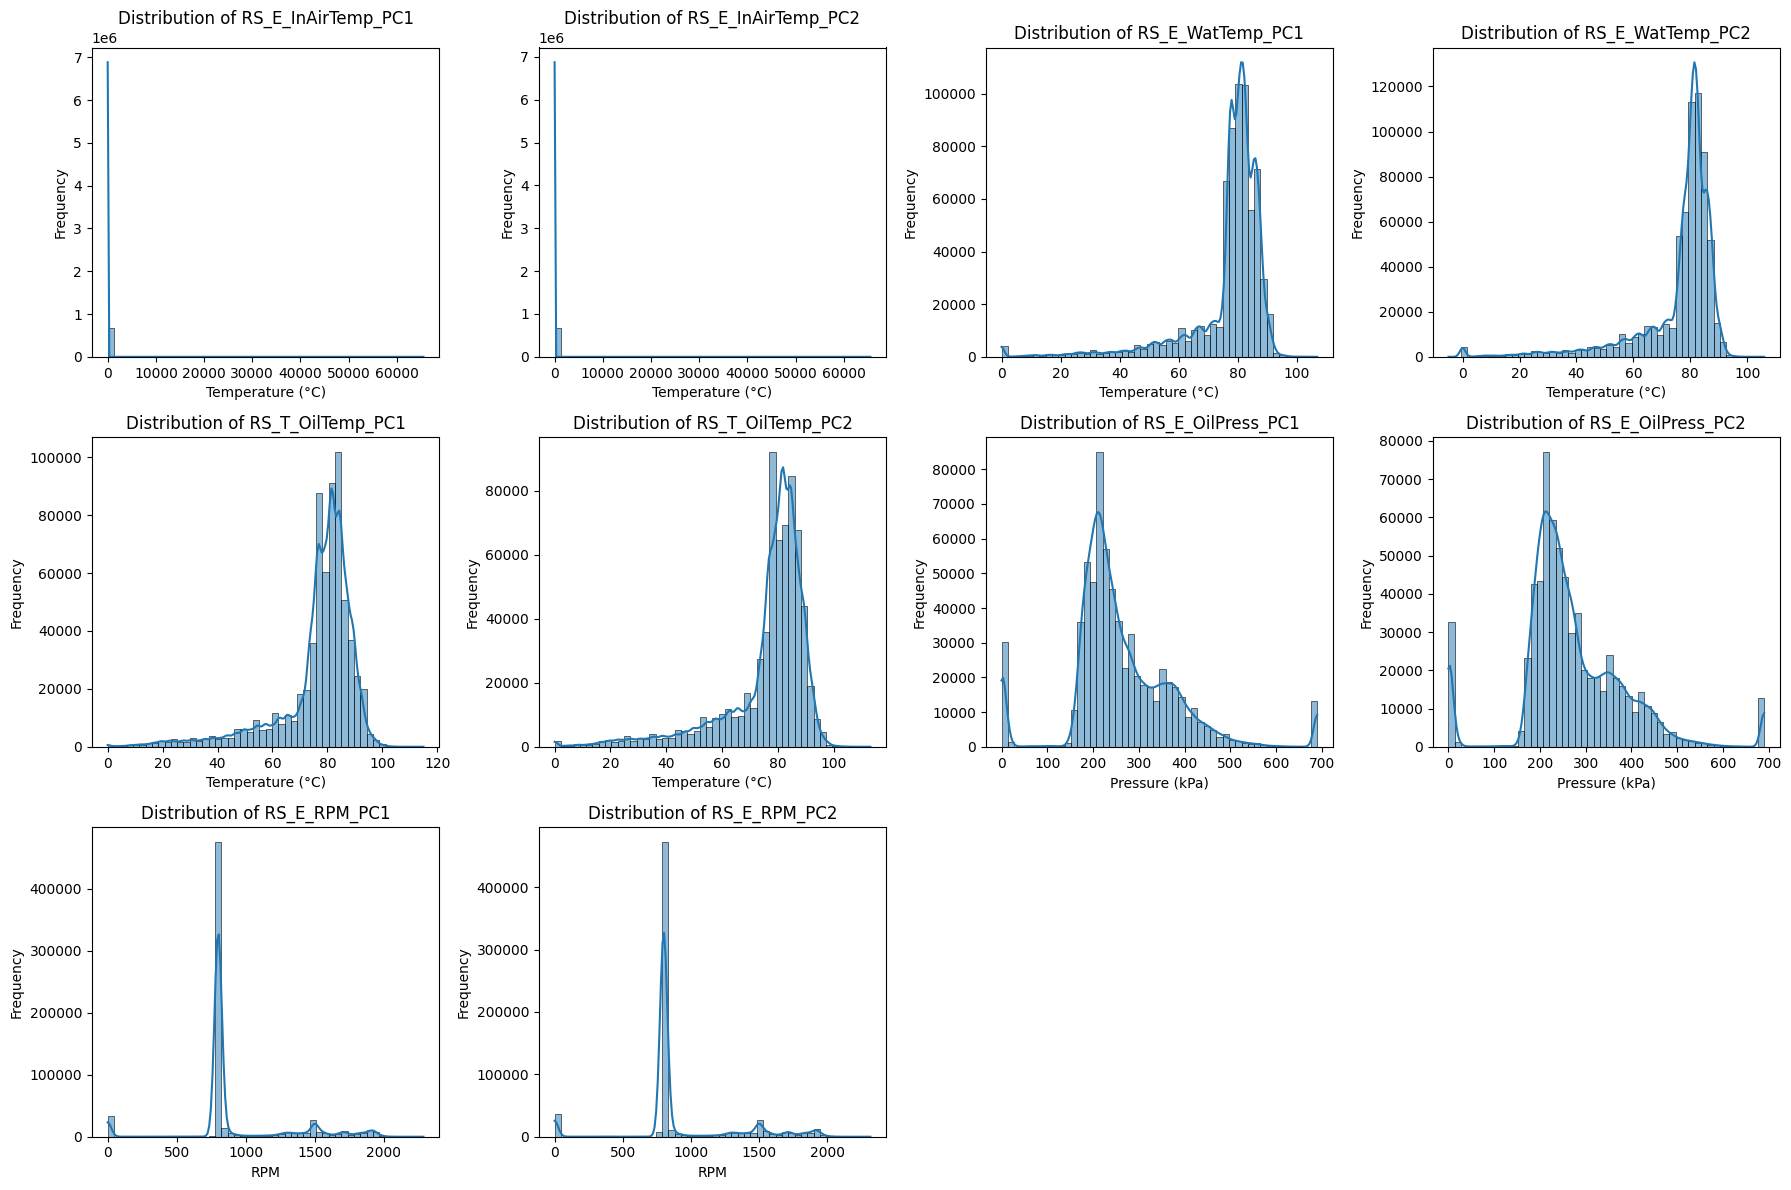

In [34]:
# Key variables for analysis
temperature_columns = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
                       'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
                       'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2']
pressure_columns = ['RS_E_OilPress_PC1', 'RS_E_OilPress_PC2']
rpm_columns = ['RS_E_RPM_PC1', 'RS_E_RPM_PC2']

# Plotting distributions of key variables
plt.figure(figsize=(18, 12))

# Temperature distributions
for i, col in enumerate(temperature_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[data[col].notna()][col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')

# Pressure distributions
for i, col in enumerate(pressure_columns, 1):
    plt.subplot(3, 4, i+6)
    sns.histplot(data[data[col].notna()][col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Pressure (kPa)')
    plt.ylabel('Frequency')

# RPM distributions
for i, col in enumerate(rpm_columns, 1):
    plt.subplot(3, 4, i+8)
    sns.histplot(data[data[col].notna()][col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('RPM')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

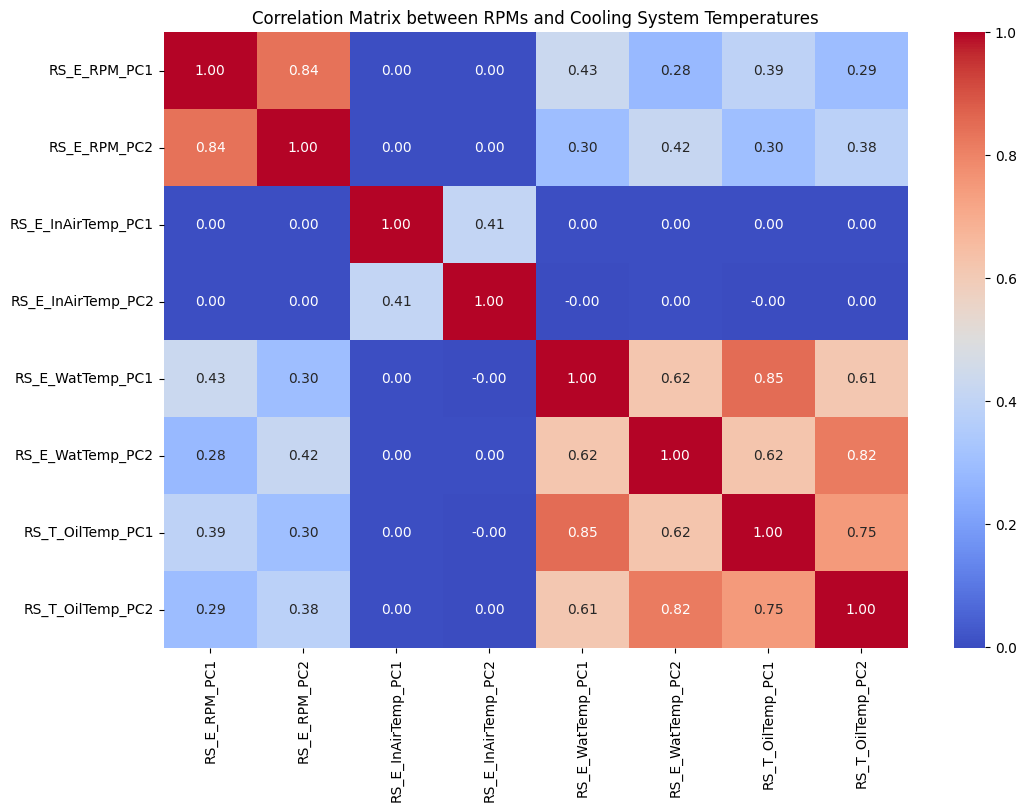

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [45]:
# Correlation Analysis between RPMs and Cooling System Temperatures

# Selecting RPM and temperature columns for correlation analysis
correlation_columns = rpm_columns + temperature_columns
correlation_data = data[correlation_columns]

# Calculating the correlation matrix
corr_matrix = correlation_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between RPMs and Cooling System Temperatures")
plt.show()

# Scatter plots for RPMs vs. Cooling System Temperatures
plt.figure(figsize=(18, 12))

# Checking the number of outliers in each major features (columns)

In [35]:
# Define key columns to check for outliers
key_columns = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
               'RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 
               'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 
               'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2']

# Function to calculate IQR and identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identify outliers in key columns
outliers_summary = {}
for column in key_columns:
    outliers = identify_outliers(data, column)
    outliers_summary[column] = len(outliers)

outliers_summary_df = pd.DataFrame(list(outliers_summary.items()), columns=['Column', 'Number of Outliers'])
outliers_summary_df.sort_values(by='Number of Outliers', ascending=False)

,Column,Number of Outliers
5,RS_E_RPM_PC2,188904
4,RS_E_RPM_PC1,186180
7,RS_E_WatTemp_PC2,96901
6,RS_E_WatTemp_PC1,87895
3,RS_E_OilPress_PC2,53409
2,RS_E_OilPress_PC1,52904
1,RS_E_InAirTemp_PC2,2254
0,RS_E_InAirTemp_PC1,1685


# Calculating the mean value of outliers for InAirTempPC1 and InAirTempPC2 (The mean value doesn't make any sense just beacuse of the unrealistic temperature values)

In [51]:
def identify_outliers_with_mean(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    mean_outliers = outliers[column].mean() if not outliers.empty else None
    return len(outliers), mean_outliers

# Identify outliers and their mean in key columns
outliers_summary = {}
for column in key_columns:
    num_outliers, mean_outlier_value = identify_outliers_with_mean(data, column)
    outliers_summary[column] = {'Number of Outliers': num_outliers, 'Mean Value': mean_outlier_value}

outliers_summary_df = pd.DataFrame.from_dict(outliers_summary, orient='index').reset_index()
outliers_summary_df.rename(columns={'index': 'Column'}, inplace=True)
outliers_summary_df.sort_values(by='Number of Outliers', ascending=False)

,Column,Number of Outliers,Mean Value
1,RS_E_InAirTemp_PC2,2254,663.475821
0,RS_E_InAirTemp_PC1,1685,806.761523


# Checking the number of outlier in a day (by hour)

In [77]:
data['timestamps_floor'] = pd.to_datetime(data['timestamps_floor'])
# Identifying outliers for RPM and Air Temperature
rpm_pc1_outliers = identify_outliers(data, 'RS_E_RPM_PC1')
rpm_pc2_outliers = identify_outliers(data, 'RS_E_RPM_PC2')
air_temp_pc1_outliers = identify_outliers(data, 'RS_E_InAirTemp_PC1')
air_temp_pc2_outliers = identify_outliers(data, 'RS_E_InAirTemp_PC2')

# Analyzing RPM outliers: checking if they are associated with specific times or other conditions

# Analyze the distribution of outliers over time (hour of the day, day of the week)
rpm_pc1_outliers['hour'] = rpm_pc1_outliers['timestamps_floor'].dt.hour
rpm_pc2_outliers['hour'] = rpm_pc2_outliers['timestamps_floor'].dt.hour
rpm_pc1_hour_distribution = rpm_pc1_outliers['hour'].value_counts().sort_index()
rpm_pc2_hour_distribution = rpm_pc2_outliers['hour'].value_counts().sort_index()

# Since we don't have external temperature data, we'll skip the correlation analysis between water temperature and external temperature

rpm_pc1_hour_distribution, rpm_pc2_hour_distribution

C:\Users\Konok\AppData\Local\Temp\ipykernel_1992\2730865201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpm_pc1_outliers['hour'] = rpm_pc1_outliers['timestamps_floor'].dt.hour
C:\Users\Konok\AppData\Local\Temp\ipykernel_1992\2730865201.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpm_pc2_outliers['hour'] = rpm_pc2_outliers['timestamps_floor'].dt.hour


(hour
 0       5
 1      10
 2       5
 3      30
 4      76
 5     103
 6     114
 7     100
 8     103
 9      94
 10     98
 11    108
 12    100
 13     91
 14    101
 15    109
 16    127
 17    116
 18     88
 19    109
 20     97
 21     65
 22     23
 Name: count, dtype: int64,
 hour
 0      18
 1      10
 2       9
 3      35
 4      75
 5     103
 6     114
 7      99
 8      98
 9      93
 10     98
 11    103
 12    105
 13     85
 14    107
 15    108
 16    128
 17    119
 18     82
 19    105
 20    100
 21     63
 22     22
 23     15
 Name: count, dtype: int64)

# Plotting outlier distributions by the day of a week and by months

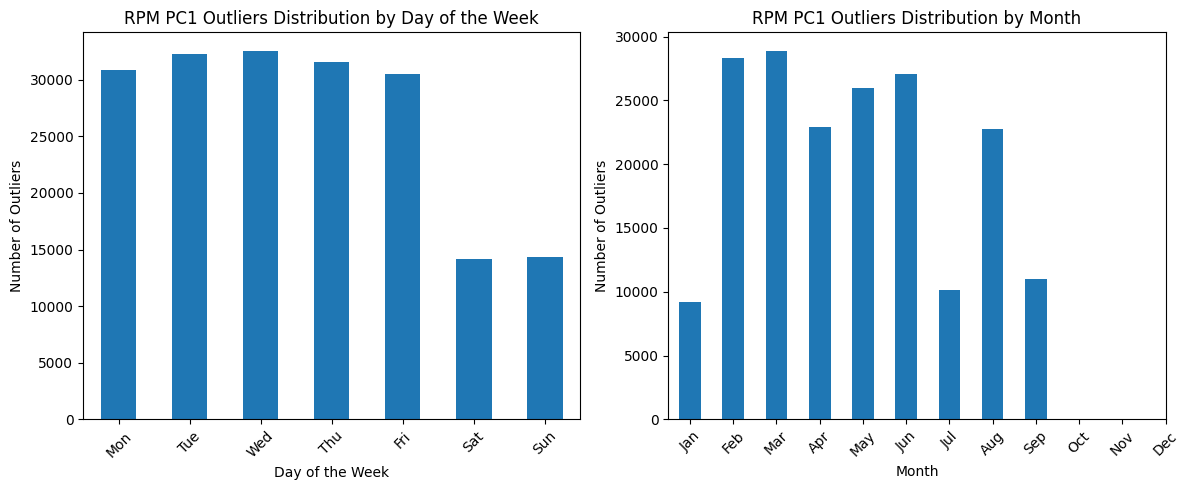

In [41]:
# Extracting day of the week and month from the timestamp
data['day_of_week'] = data['timestamps_floor'].dt.dayofweek  # Monday=0, Sunday=6
data['month'] = data['timestamps_floor'].dt.month

# Identifying outliers for a specific variable, e.g., RS_E_RPM_PC1
rpm_pc1_outliers = identify_outliers(data, 'RS_E_RPM_PC1')

# Grouping outliers by day of the week and month
outliers_by_day = rpm_pc1_outliers['day_of_week'].value_counts().sort_index()
outliers_by_month = rpm_pc1_outliers['month'].value_counts().sort_index()

# Plotting the distribution of outliers
plt.figure(figsize=(12, 5))

# Outliers by day of the week
plt.subplot(1, 2, 1)
outliers_by_day.plot(kind='bar')
plt.title('RPM PC1 Outliers Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Outliers')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

# Outliers by month
plt.subplot(1, 2, 2)
outliers_by_month.plot(kind='bar')
plt.title('RPM PC1 Outliers Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Outliers')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

# Number of outliers in seasonal trends

In [52]:
# Function to define seasons based on the month
def season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the season function to the month column
data['season'] = data['month'].apply(season)

# Grouping data by season
grouped_by_season = data.groupby('season')

# Identifying outliers for each season
seasonal_outliers = {season: identify_outliers(group, 'RS_E_RPM_PC1') for season, group in grouped_by_season}

# Now, for geographical segmentation, we'll create a simple segmentation based on latitude
# Assuming latitude < 50.5 as 'South' and >= 50.5 as 'North'
data['region'] = np.where(data['lat'] < 50.5, 'South', 'North')

# Grouping data by region
grouped_by_region = data.groupby('region')

# Identifying outliers for each region
regional_outliers = {region: identify_outliers(group, 'RS_E_RPM_PC1') for region, group in grouped_by_region}

# Counting the number of outliers in each season and region
seasonal_outliers_count = {season: len(df) for season, df in seasonal_outliers.items()}
regional_outliers_count = {region: len(df) for region, df in regional_outliers.items()}

seasonal_outliers_count, regional_outliers_count

({'Fall': 11046, 'Spring': 77753, 'Summer': 59248, 'Winter': 37983},
 {'North': 154536, 'South': 25503})

# Number of Anomalies after defining the given threshold values

In [53]:
# Define the maximum acceptable temperatures
MAX_AIR_TEMP = 65  # in degrees Celsius
MAX_WATER_TEMP = 100
MAX_OIL_TEMP = 115

# Function to check if the temperature exceeds the threshold
def is_anomaly_air(temp):
    return temp > MAX_AIR_TEMP

def is_anomaly_water(temp):
    return temp > MAX_WATER_TEMP

def is_anomaly_oil(temp):
    return temp > MAX_OIL_TEMP

# Apply the functions to your dataset
data['Anomaly_Air_PC1'] = data['RS_E_InAirTemp_PC1'].apply(is_anomaly_air)
data['Anomaly_Air_PC2'] = data['RS_E_InAirTemp_PC2'].apply(is_anomaly_air)
data['Anomaly_Water_PC1'] = data['RS_E_WatTemp_PC1'].apply(is_anomaly_water)
data['Anomaly_Water_PC2'] = data['RS_E_WatTemp_PC2'].apply(is_anomaly_water)
data['Anomaly_Oil_PC1'] = data['RS_T_OilTemp_PC1'].apply(is_anomaly_oil)
data['Anomaly_Oil_PC2'] = data['RS_T_OilTemp_PC2'].apply(is_anomaly_oil)

# Counting the number of True values (anomalies) in each anomaly column
anomaly_air_count = data['Anomaly_Air_PC1'].sum()
anomaly_water_count = data['Anomaly_Water_PC1'].sum()
anomaly_oil_count = data['Anomaly_Oil_PC1'].sum()

# Displaying the count of anomalies
print(f"Number of Air Temperature Anomalies (PC1): {anomaly_air_count}")
print(f"Number of Water Temperature Anomalies (PC1): {anomaly_water_count}")
print(f"Number of Oil Temperature Anomalies (PC1): {anomaly_oil_count}")

Number of Air Temperature Anomalies (PC1): 1368
Number of Water Temperature Anomalies (PC1): 54
Number of Oil Temperature Anomalies (PC1): 0


# Plotting the anomalies

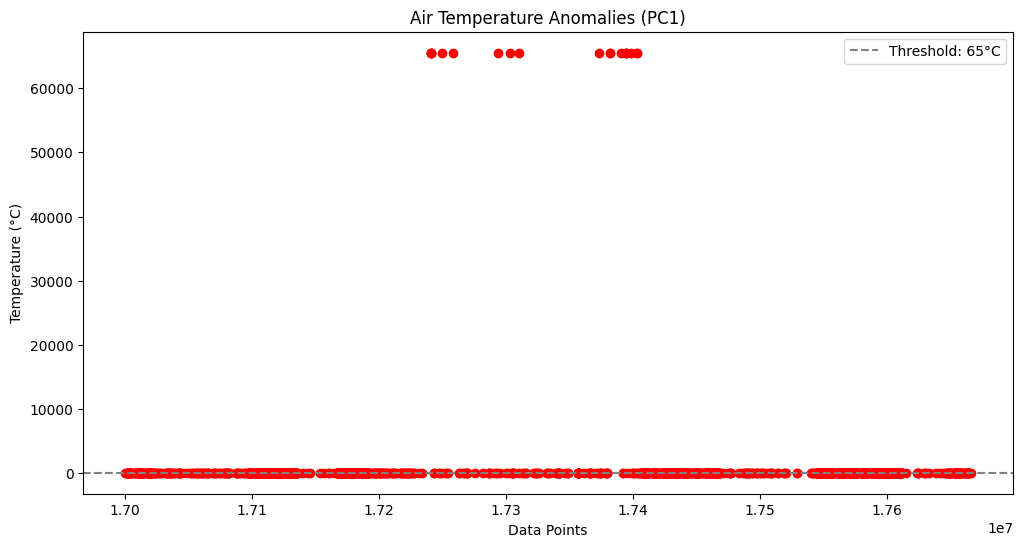

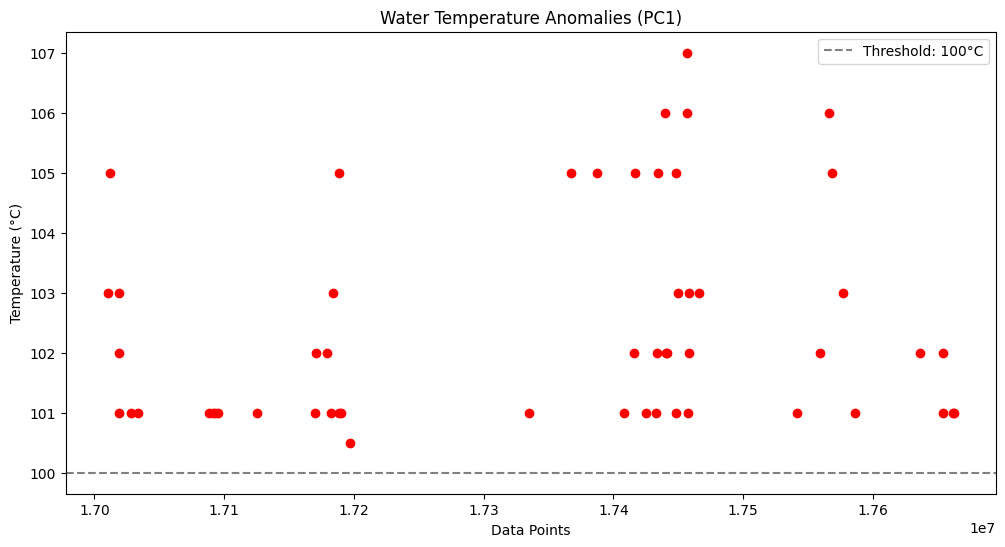

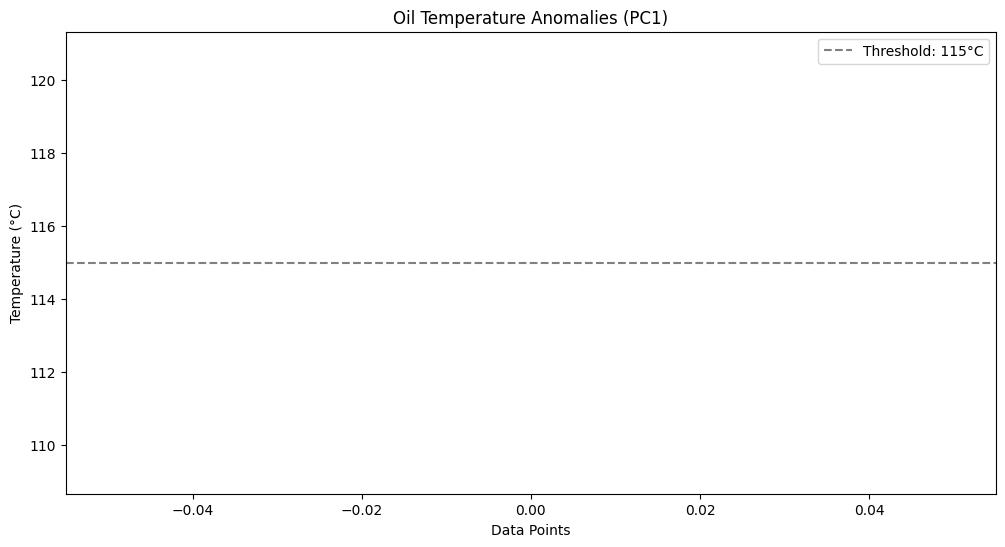

In [54]:
# Function to plot anomalies for a given feature
def plot_anomalies(data, feature, threshold, title):
    plt.figure(figsize=(12, 6))
    # Plot only the anomaly points
    anomalies = data[data[feature] > threshold]
    plt.scatter(anomalies.index, anomalies[feature], color='red')
    plt.title(title)
    plt.xlabel('Data Points')
    plt.ylabel('Temperature (°C)')
    plt.axhline(y=threshold, color='grey', linestyle='--', label=f'Threshold: {threshold}°C')
    plt.legend()
    plt.show()

# Air Temperature Anomalies (PC1)
plot_anomalies(data, 'RS_E_InAirTemp_PC1', MAX_AIR_TEMP, 'Air Temperature Anomalies (PC1)')

# Water Temperature Anomalies (PC1)
plot_anomalies(data, 'RS_E_WatTemp_PC1', MAX_WATER_TEMP, 'Water Temperature Anomalies (PC1)')

# Oil Temperature Anomalies (PC1)
plot_anomalies(data, 'RS_T_OilTemp_PC1', MAX_OIL_TEMP, 'Oil Temperature Anomalies (PC1)')

# Scatter plot to evaluate RPM values of a engine with temperature

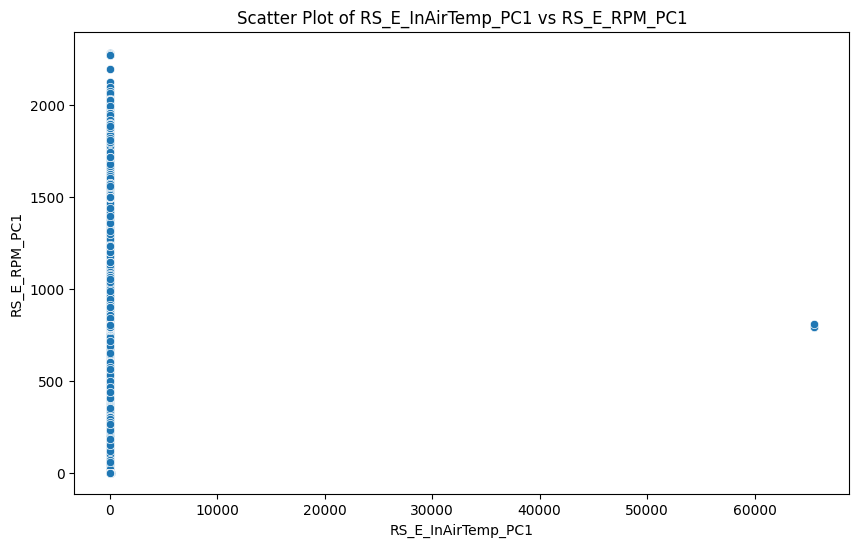

In [55]:
# Scatter plot for RS_E_InAirTemp_PC1 vs RS_E_RPM_PC1
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RS_E_InAirTemp_PC1', y='RS_E_RPM_PC1', data=data)

plt.title('Scatter Plot of RS_E_InAirTemp_PC1 vs RS_E_RPM_PC1')
plt.xlabel('RS_E_InAirTemp_PC1')
plt.ylabel('RS_E_RPM_PC1')
plt.show()